# Развёртывание датасета

Импортируем необходимые библиотеки

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot



from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
from pandas.tseries.offsets import DateOffset

Загружаем данные

In [2]:
dataset = pd.concat(map(lambda file: pd.read_csv(file, usecols=['Issue Date', 'Vehicle Make', 'House Number', 'Street Name', 'Vehicle Year'], 
                    dtype={'Issue Date' : 'object', 'Vehicle Make' : 'string[pyarrow]', 'House Number' : 'string[pyarrow]', 'Street Name' : 'string[pyarrow]', 'Vehicle Year' : 'float16'}, 
                    parse_dates=['Issue Date']), 
                   ['Parking_Violations_Issued_-_Fiscal_Year_2014.csv', 
                    'Parking_Violations_Issued_-_Fiscal_Year_2015.csv',
                    'Parking_Violations_Issued_-_Fiscal_Year_2016.csv', 
                    'Parking_Violations_Issued_-_Fiscal_Year_2017.csv', 
                    'Parking_Violations_Issued_-_Fiscal_Year_2018.csv', 
                    'Parking_Violations_Issued_-_Fiscal_Year_2019.csv',
                    'Parking_Violations_Issued_-_Fiscal_Year_2020.csv', 
                    'Parking_Violations_Issued_-_Fiscal_Year_2021.csv', 
                    'Parking_Violations_Issued_-_Fiscal_Year_2022.csv']))

In [3]:
dataset['Vehicle Make'] = dataset['Vehicle Make'].astype('category')
dataset['Street Name'] = dataset['Street Name'].astype('category')

In [4]:
dataset.memory_usage(deep=True)

Index           834956760
Issue Date      834956760
Vehicle Make    209480419
House Number    680328711
Street Name     432182418
Vehicle Year    208739190
dtype: int64

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104369595 entries, 0 to 11389767
Data columns (total 5 columns):
 #   Column        Dtype         
---  ------        -----         
 0   Issue Date    datetime64[ns]
 1   Vehicle Make  category      
 2   House Number  string        
 3   Street Name   category      
 4   Vehicle Year  float16       
dtypes: category(2), datetime64[ns](1), float16(1), string(1)
memory usage: 3.0 GB


Оставляем в датасете только те строки, в которых дата "происшествия" находится в периоде между 2015-01-01 и 2021-12-31.

In [6]:
dataset = dataset.loc[((dataset['Issue Date'] >= pd.Timestamp('2015-01-01')) & (dataset['Issue Date'] <= pd.Timestamp('2021-12-31'))) & 
                      ((dataset['Vehicle Year'] >= 1900.0) & (dataset['Vehicle Year'] <= 2022.0))]

In [7]:
dataset.head()

,Issue Date,Vehicle Make,House Number,Street Name,Vehicle Year
9064485,2015-04-23,NISSA,81-01,BCD,2010.0
9064775,2015-05-23,CHEVR,<NA>,<NA>,2007.0
9065938,2015-10-02,FORD,12,W 72,2007.0
9067348,2018-05-24,HONDA,<NA>,LGA LOT 5,2008.0
9068156,2019-07-22,FORD,<NA>,C/O 68 ST,2010.0


In [8]:
dataset.tail()

,Issue Date,Vehicle Make,House Number,Street Name,Vehicle Year
11330481,2021-12-02,BMW,2526,Bronx Park East,2014.0
11330483,2021-12-02,AUDI,2566,Radcliff Ave,2021.0
11330484,2021-12-02,ACURA,2512,Hone Ave,2002.0
11330485,2021-12-02,HONDA,2553,Williamsbridge Rd,2003.0
11330486,2021-12-02,TESLA,908,Allerton Ave,2021.0


# Визуализируем датасет

### Проанализируем данные о всех штрафах

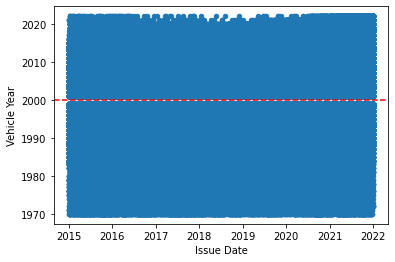

In [9]:
ax = dataset.plot(kind='scatter', x='Issue Date', y='Vehicle Year')
ax.axhline(2000, color="red", linestyle="--")

Красная вертикальная линия отделяет штрафы, полученные машинами выпущенные до 2000 года и после.

### Рассмотрим отдельно графики для машин разных марок.

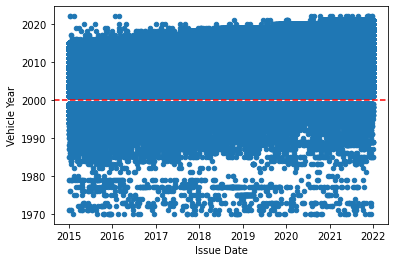

In [10]:
ax = dataset.loc[dataset['Vehicle Make']=='DODGE'].plot(kind='scatter', x='Issue Date', y='Vehicle Year')
ax.axhline(2000, color="red", linestyle="--")

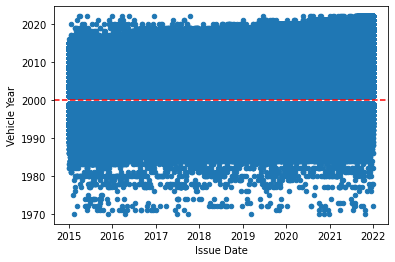

In [11]:
ax = dataset.loc[dataset['Vehicle Make']=='TOYOT'].plot(kind='scatter', x='Issue Date', y='Vehicle Year')
ax.axhline(2000, color="red", linestyle="--")

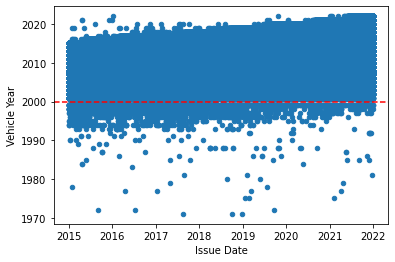

In [12]:
ax = dataset.loc[dataset['Vehicle Make']=='HYUND'].plot(kind='scatter', x='Issue Date', y='Vehicle Year')
ax.axhline(2000, color="red", linestyle="--")

Меньше всего штрафов получили Hyundai, выпущенные до 2000 года. Остальные марки получили примерное одинаковое количество штрафов.

### Сделаем поле Issue Date индексом

In [13]:
dataset.set_index('Issue Date', inplace=True)

### Рассмотрим где чаще всего происходили нарушения

Выведем список улиц, которые находятся в топе по количеству нарушений

In [14]:
dataset_bystreet = dataset['Street Name'].value_counts().head(5)
dataset_bystreet.index.astype('object')

Index(['Broadway', '3rd Ave', '5th Ave', 'Madison Ave', '2nd Ave'], dtype='object')

<AxesSubplot:>

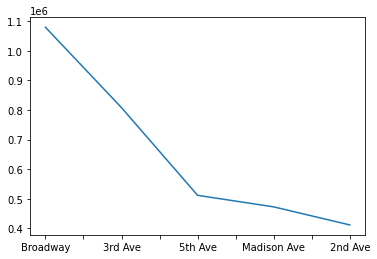

In [15]:
dataset_bystreet.plot()

Выведем для вышеперечисленных улиц номера домов, где чаще всего происходят нарушения

In [16]:
dataset.loc[dataset['Street Name'].isin(dataset_bystreet.index)].groupby('Street Name', observed=True)['House Number'].value_counts().rename_axis(['Street Name','House Number']).reset_index(name='freq').drop_duplicates('Street Name')

,Street Name,House Number,freq
0,2nd Ave,E,22843
2721,5th Ave,E,24214
6496,3rd Ave,W,42201
11608,Broadway,W,46541
19444,Madison Ave,W,39895


### Рассмотрим результаты отдельно для машин разных марок

#### Dodge

##### До 2000 года

In [17]:
dataset_bystreet = dataset.loc[(dataset['Vehicle Year'] < 2000.0) & (dataset['Vehicle Make']=='DODGE')]['Street Name'].value_counts().head(5)

<AxesSubplot:>

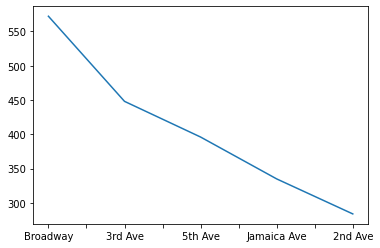

In [18]:
dataset_bystreet.plot()

In [19]:
dataset.loc[(dataset['Vehicle Year'] < 2000.0) & (dataset['Vehicle Make']=='DODGE') & ((dataset['Street Name'].isin(dataset_bystreet.index)))].groupby('Street Name', observed=True)['House Number'].value_counts().rename_axis(['Street Name','House Number']).reset_index(name='freq').drop_duplicates('Street Name')

,Street Name,House Number,freq
0,2nd Ave,1546,17
110,3rd Ave,W,18
401,Broadway,3447,14
791,Jamaica Ave,216-05,14
1011,5th Ave,E,21


##### После 2000 года

In [20]:
dataset_bystreet = dataset.loc[(dataset['Vehicle Year'] >= 2000.0) & (dataset['Vehicle Make']=='DODGE')]['Street Name'].value_counts().head(5)

<AxesSubplot:>

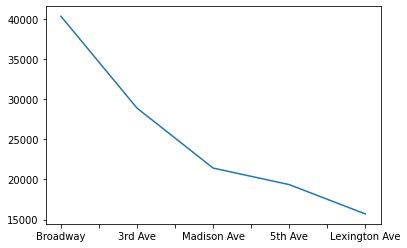

In [21]:
dataset_bystreet.plot()

In [22]:
dataset.loc[(dataset['Vehicle Year'] >= 2000.0) & (dataset['Vehicle Make']=='DODGE') & ((dataset['Street Name'].isin(dataset_bystreet.index)))].groupby('Street Name', observed=True)['House Number'].value_counts().rename_axis(['Street Name','House Number']).reset_index(name='freq').drop_duplicates('Street Name')

,Street Name,House Number,freq
0,3rd Ave,W,1619
2206,5th Ave,E,1066
3910,Madison Ave,W,1636
4823,Lexington Ave,E,803
5809,Broadway,E,1714


#### Toyota

##### До 2000 года

In [23]:
dataset_bystreet = dataset.loc[(dataset['Vehicle Year'] < 2000.0) & (dataset['Vehicle Make']=='TOYOT')]['Street Name'].value_counts().head(5)

<AxesSubplot:>

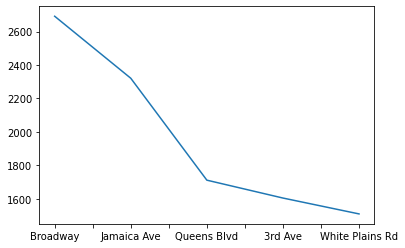

In [24]:
dataset_bystreet.plot()

In [25]:
dataset.loc[(dataset['Vehicle Year'] < 2000.0) & (dataset['Vehicle Make']=='TOYOT') & ((dataset['Street Name'].isin(dataset_bystreet.index)))].groupby('Street Name', observed=True)['House Number'].value_counts().rename_axis(['Street Name','House Number']).reset_index(name='freq').drop_duplicates('Street Name')

,Street Name,House Number,freq
0,Broadway,W,96
1209,Jamaica Ave,N,70
2224,White Plains Rd,2901,28
2793,3rd Ave,E,74
3566,Queens Blvd,N,112


##### После 2000 года

In [26]:
dataset_bystreet = dataset.loc[(dataset['Vehicle Year'] >= 2000.0) & (dataset['Vehicle Make']=='TOYOT')]['Street Name'].value_counts().head(5)

<AxesSubplot:>

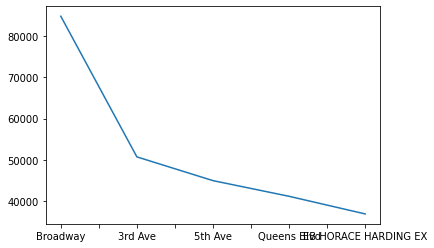

In [27]:
dataset_bystreet.plot()

In [28]:
dataset.loc[(dataset['Vehicle Year'] >= 2000.0) & (dataset['Vehicle Make']=='TOYOT') & ((dataset['Street Name'].isin(dataset_bystreet.index)))].groupby('Street Name', observed=True)['House Number'].value_counts().rename_axis(['Street Name','House Number']).reset_index(name='freq').drop_duplicates('Street Name')

,Street Name,House Number,freq
0,Queens Blvd,N,2946
1854,Broadway,W,3048
5895,3rd Ave,W,2260
8577,5th Ave,E,1379


#### Hyundai

##### До 2000 года

In [29]:
dataset_bystreet = dataset.loc[(dataset['Vehicle Year'] < 2000.0) & (dataset['Vehicle Make']=='HYUND')]['Street Name'].value_counts().head(5)

<AxesSubplot:>

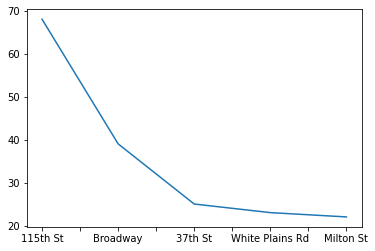

In [30]:
dataset_bystreet.plot()

In [31]:
dataset.loc[(dataset['Vehicle Year'] < 2000.0) & (dataset['Vehicle Make']=='HYUND') & ((dataset['Street Name'].isin(dataset_bystreet.index)))].groupby('Street Name', observed=True)['House Number'].value_counts().rename_axis(['Street Name','House Number']).reset_index(name='freq').drop_duplicates('Street Name')

,Street Name,House Number,freq
0,Broadway,789,3
32,White Plains Rd,2100,7
46,37th St,25-41,7
60,Milton St,144,5
70,115th St,89-14,26


##### После 2000 года

In [32]:
dataset_bystreet = dataset.loc[(dataset['Vehicle Year'] >= 2000.0) & (dataset['Vehicle Make']=='HYUND')]['Street Name'].value_counts().head(5)

<AxesSubplot:>

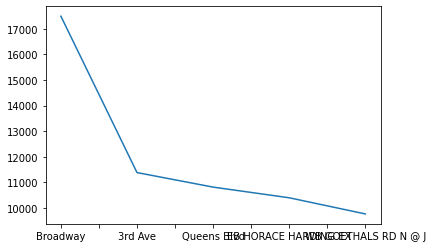

In [33]:
dataset_bystreet.plot()

In [34]:
dataset.loc[(dataset['Vehicle Year'] >= 2000.0) & (dataset['Vehicle Make']=='HYUND') & ((dataset['Street Name'].isin(dataset_bystreet.index)))].groupby('Street Name', observed=True)['House Number'].value_counts().rename_axis(['Street Name','House Number']).reset_index(name='freq').drop_duplicates('Street Name')

,Street Name,House Number,freq
0,Broadway,W,616
2571,3rd Ave,W,518
4366,Queens Blvd,N,715


### Рассмотрим штрафы машин ежемесячно

#### До 2000 года.

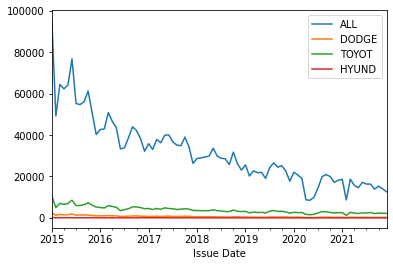

In [35]:
fig, ax = plt.subplots()
pd.DataFrame(dataset.loc[dataset['Vehicle Year'] < 2000.0].reset_index().groupby(['Issue Date'])['Issue Date'].agg('count').groupby(pd.Grouper(freq='M')).agg('sum')).rename(columns={'Issue Date' : 'Fines'}).plot(legend=True, ax=ax)
pd.DataFrame(dataset.loc[(dataset['Vehicle Make']=='DODGE') & (dataset['Vehicle Year'] < 2000.0)].reset_index().groupby(['Issue Date'])['Issue Date'].agg('count').groupby(pd.Grouper(freq='M')).agg('sum')).rename(columns={'Issue Date' : 'Fines'}).plot(legend=True, ax=ax)
pd.DataFrame(dataset.loc[(dataset['Vehicle Make']=='TOYOT') & (dataset['Vehicle Year'] < 2000.0)].reset_index().groupby(['Issue Date'])['Issue Date'].agg('count').groupby(pd.Grouper(freq='M')).agg('sum')).rename(columns={'Issue Date' : 'Fines'}).plot(legend=True, ax=ax)
pd.DataFrame(dataset.loc[(dataset['Vehicle Make']=='HYUND') & (dataset['Vehicle Year'] < 2000.0)].reset_index().groupby(['Issue Date'])['Issue Date'].agg('count').groupby(pd.Grouper(freq='M')).agg('sum')).rename(columns={'Issue Date' : 'Fines'}).plot(legend=True, ax=ax)
plt.legend(['ALL', 'DODGE', 'TOYOT', 'HYUND']);

Как видно на графике, больше всего штрафов получают машины марки "Toyota", затем идут "Dodge, ну и последними, практически с нулем штрафов идут машины марки "Hyundai".

#### После 2000 года.

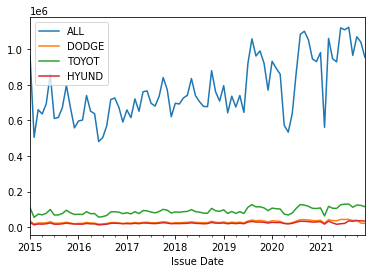

In [36]:
fig, ax = plt.subplots()
pd.DataFrame(dataset.loc[dataset['Vehicle Year'] >= 2000.0].reset_index().groupby(['Issue Date'])['Issue Date'].agg('count').groupby(pd.Grouper(freq='M')).agg('sum')).rename(columns={'Issue Date' : 'Fines'}).plot(legend=True, ax=ax)
pd.DataFrame(dataset.loc[(dataset['Vehicle Make']=='DODGE') & (dataset['Vehicle Year'] >= 2000.0)].reset_index().groupby(['Issue Date'])['Issue Date'].agg('count').groupby(pd.Grouper(freq='M')).agg('sum')).rename(columns={'Issue Date' : 'Fines'}).plot(legend=True, ax=ax)
pd.DataFrame(dataset.loc[(dataset['Vehicle Make']=='TOYOT') & (dataset['Vehicle Year'] >= 2000.0)].reset_index().groupby(['Issue Date'])['Issue Date'].agg('count').groupby(pd.Grouper(freq='M')).agg('sum')).rename(columns={'Issue Date' : 'Fines'}).plot(legend=True, ax=ax)
pd.DataFrame(dataset.loc[(dataset['Vehicle Make']=='HYUND') & (dataset['Vehicle Year'] >= 2000.0)].reset_index().groupby(['Issue Date'])['Issue Date'].agg('count').groupby(pd.Grouper(freq='M')).agg('sum')).rename(columns={'Issue Date' : 'Fines'}).plot(legend=True, ax=ax)
plt.legend(['ALL', 'DODGE', 'TOYOT', 'HYUND']);

Здесь ситуация не сильно изменилась, единственное: машины марки "Hyundai" получили гораздно больше штрафов, практически столько же, сколько и машины марки "Dodge".

### Сгруппируем данные по месяцам и количеству штрафов в этот месяц

In [37]:
dataset = pd.DataFrame(dataset.reset_index().groupby(['Issue Date'])['Issue Date'].agg('count').groupby(pd.Grouper(freq='M')).agg('sum')).rename(columns={'Issue Date' : 'Fines'})

### Дифференциация

In [38]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [39]:
adfuller_test(dataset['Fines'])

ADF Test Statistic : -4.5508178280071565
p-value : 0.0001589924610356828
#Lags Used : 0
Number of Observations Used : 83
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


Так как данные изначально стационарны, дифференциация не требуется.

<AxesSubplot:xlabel='Issue Date'>

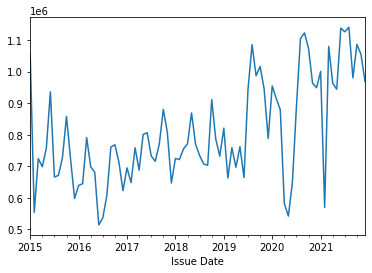

In [40]:
dataset['Fines'].dropna().plot()

### Авторегрессионная модель

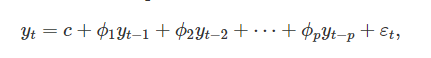

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

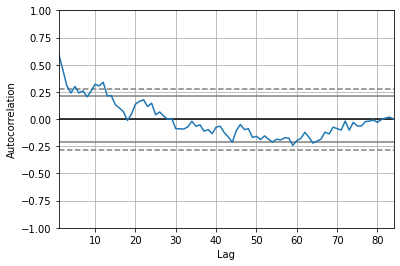

In [41]:
autocorrelation_plot(dataset['Fines'])

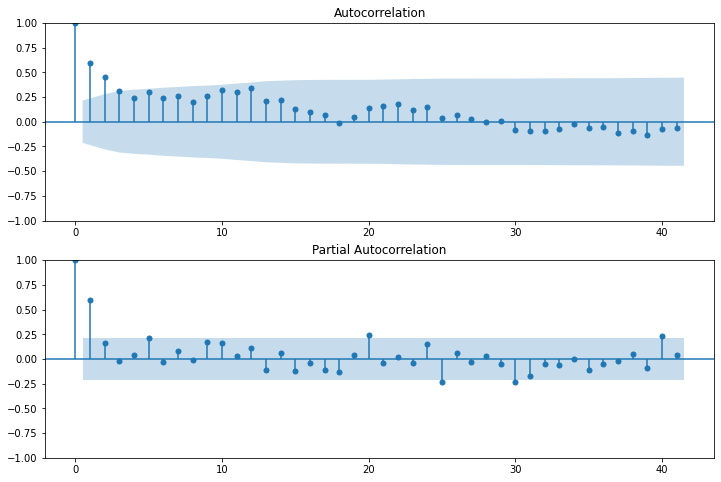

In [97]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(dataset['Fines'], lags=41, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(dataset['Fines'],lags=41, ax=ax2)

- p = 1, так на графике частичной автокорреляции максимальное количество "заметных" (выходящих за синюю область) лагов подряд равнялось одному,
- P = 1, так как на графике частичной автокорреляции максимальное количество "заметных" (выходящих за синюю область) сезонных лагов подряд равнялось одному,
- q = 2, так на графике автокорреляции максимальное количество "заметных" (выходящих за синюю область) лагов подряд равнялось двум,
- Q = 0, так как на графике автокорреляции максимальное количество "заметных" (выходящих за синюю область) сезонных лагов подряд равнялось нулю.

In [98]:
model=sm.tsa.arima.ARIMA(dataset['Fines'],order=(1,0,2))
model_fit=model.fit()

In [99]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Fines   No. Observations:                   84
Model:                 ARIMA(1, 0, 2)   Log Likelihood               -1107.085
Date:                Wed, 27 Apr 2022   AIC                           2224.170
Time:                        23:03:20   BIC                           2236.324
Sample:                    01-31-2015   HQIC                          2229.056
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.081e+05   7.44e+04     10.867      0.000    6.62e+05    9.54e+05
ar.L1          0.9700      0.066     14.749      0.000       0.841       1.099
ma.L1         -0.5328      0.114     -4.678      0.000      -0.756      -0.310
ma.L2         -0.2372      0.104     -2.288      0.022      -0.440      -0.034
sigma2      1.443e+10      0.250   5.77e+10      0.000    1.44e+10    1.44e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                 6.49
Prob(Q):                              0.79   Prob(JB):                         0.04
Heteroskedasticity (H):               1.76   Skew:                            -0.38
Prob(H) (two-sided):                  0.14   Kurtosis:                         4.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.97e+26. Standard errors may be unstable.
"""

<AxesSubplot:xlabel='Issue Date'>

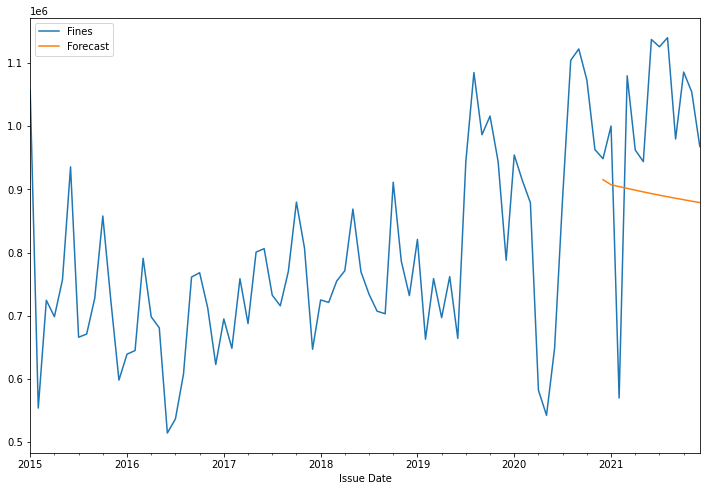

In [100]:
dataset['Forecast']=model_fit.predict(start=71,end=83,dynamic=True)
dataset[['Fines','Forecast']].plot(figsize=(12,8))

In [265]:
model=sm.tsa.statespace.SARIMAX(dataset['Fines'],order=(1, 0, 2),seasonal_order=(1,1,0,12))
results=model.fit()

<AxesSubplot:xlabel='Issue Date'>

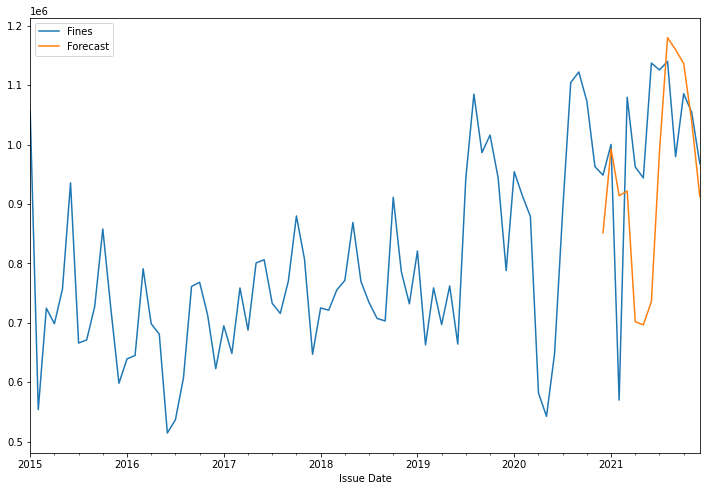

In [266]:
dataset['Forecast']=results.predict(start=71,end=83,dynamic=True)
dataset[['Fines','Forecast']].plot(figsize=(12,8))

In [267]:
future_dates=[dataset.index[-1]+ DateOffset(months=x)for x in range(0,24)]

In [268]:
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=dataset.columns)

In [269]:
future_datest_df.tail()

,Fines,Forecast
2023-07-31,NaN,NaN
2023-08-31,NaN,NaN
2023-09-30,NaN,NaN
2023-10-31,NaN,NaN
2023-11-30,NaN,NaN


In [270]:
future_df=pd.concat([dataset,future_datest_df])

<AxesSubplot:>

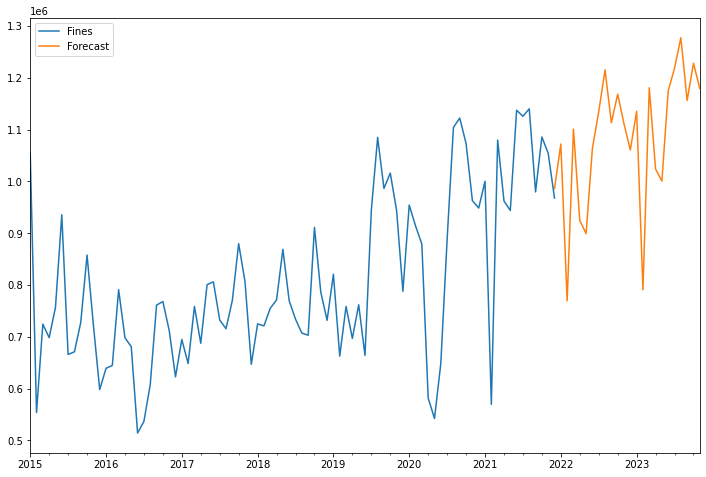

In [271]:
future_df['Forecast'] = results.predict(start = 83, end = 107, dynamic= True)  
future_df[['Fines', 'Forecast']].plot(figsize=(12, 8))